# 1. Set up

In [ ]:
from helpers import helpers as h

import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import shap
import matplotlib.pyplot as plt
from collections import Counter

from scipy.stats import loguniform
import category_encoders as ce
from joblib import dump
from plotnine import *

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

from imblearn.under_sampling import RandomUnderSampler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold , cross_validate, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay, r2_score, roc_curve, RocCurveDisplay
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss, accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, plot_confusion_matrix, f1_score, recall_score, classification_report

from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.svm import SVC, SVR

from IPython.display import Image
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline   
%load_ext blackcellmagic

In [38]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("float_format", "{:.2f}".format)

In [3]:
# Data set for predicting loan "status": acceptance or rejection.
all_loans_df = pd.read_csv("all_loans_df.csv")

In [58]:
# Data set for predicting accepted loans: grade, sub_grade and interest rate.
accepted_loans_df = pd.read_csv("accepted_loans.csv")

# 2. Loan status: accepted/rejected prediction

## 2.1. Feature pre-processing

Pre-processing steps:
1. Categorical into numerical: purpose - one hot encoding, as it has not so many values.
2. Categorical addr_state: using binary encoding [idea from here](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159);
3. Months - sin/cos encoding, idea from [here](https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca). Because otherwise the model will consider the gap between December and January - as 11 "points", and it's only 1 month away one from each other and also in the EDA we saw, that these two months are very closely related in the number of rejected loans. BUT decision trees based algorithms (Random Forest, Gradient Boosted Trees, XGBoost) build their split rules according to one feature at a time. This means that they will fail to process these two features simultaneously whereas the cos/sin values are expected to be considered as one single coordinates system, so in decision tree based model I can use only "months".
4. Numerical features - scaling. Log of loan_amnt, fico_score, dti.
5. Because of the low capability of my machine's computing power(it took ages only for the base line model to run on 2 million observations data set), I took  a sample of 100 000 observations and decided to leave test and validation data only from the year 2018, training data is from 2013 to 2017 including and also I down sample training data to be equal sizes of "0" and "1". In this way I did not touch the test and validation data and the proportion of "0" and "1" is untouched there.

In [5]:
# all_loans_df = (all_loans_df
#     .pipe(h.months_sin_cos, "month")
#     .pipe(h.log_feature, "loan_amnt")
#     .pipe(h.log_feature, "fico_score")
#     .pipe(h.log_feature, "dti")
# )

In [120]:
# all_loans_df = all_loans_df.sample(frac=0.117)

In [26]:
# Saved the sample of data, that I'll use for further modeling.
# all_loans_df.to_csv("used_sample_of_all_loans.csv", index=False)

In [40]:
sample_loans_df = pd.read_csv("used_sample_of_all_loans.csv")

In [41]:
sample_loans_df.head()

,loan_amnt,purpose,fico_score,dti,addr_state,emp_length,year,month,status,cos_month,sin_month,log_loan_amnt,log_fico_score,log_dti
0,12000.00,debt_consolidation,792.00,13.92,GA,10,2013,3,0,0.00,1.00,9.39,6.67,2.63
1,4500.00,vacation,537.00,2.66,MD,0,2017,11,0,0.87,-0.50,8.41,6.29,0.98
2,1000.00,other,582.00,16.38,MO,0,2016,4,0,-0.50,0.87,6.91,6.37,2.80
3,1800.00,other,701.00,12.79,MD,5,2014,7,0,-0.87,-0.50,7.50,6.55,2.55
4,15000.00,car,730.00,21.08,FL,0,2014,4,0,-0.50,0.87,9.62,6.59,3.05


In [42]:
len(sample_loans_df)

1107144

In [43]:
# Separating the year 2018.
val_data_2018 = sample_loans_df[sample_loans_df["year"] ==2018]
train_data = sample_loans_df[sample_loans_df["year"] != 2018]

In [44]:
X_train = train_data.drop(columns=["status"], axis=1)
y_train = train_data.status

In [45]:
X_remain = val_data_2018.drop(columns=["status"])
y_remain = val_data_2018.status
X_val, X_test, y_val, y_test = train_test_split(
    X_remain, y_remain, test_size=0.5, random_state=123
)

* Undersampling train data to be equal of both "status" groups.

In [46]:
Counter(y_train)

Counter({0: 885680, 1: 110944})

In [47]:
undersampler = RandomUnderSampler(sampling_strategy="majority", random_state=123)
# fit and apply the transform
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(y_train_under))

Counter({0: 110944, 1: 110944})


* Defining features and pre-processors.

In [49]:
numeric_features = ["loan_amnt", "fico_score", "dti", "year", "month", "cos_month", "sin_month", "log_loan_amnt", "log_fico_score", "log_dti"]
one_hot_features = ["purpose", "emp_length"]
binary_features = ["addr_state"]

In [50]:
one_hot_transformer = Pipeline(
    steps=[("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

binary_transformer = Pipeline(
    steps=[("binary_encoder", ce.BinaryEncoder(cols=binary_features))]
)

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features,),
        ("one_hot", one_hot_transformer, one_hot_features),
        ("binary", binary_transformer, binary_features),
    ]
)

## 2.2. Cross-validation of baseline models

In [ ]:
# baseline = base_line(X_train_under, y_train_under, preprocessor)

In [22]:
# baseline

,Balanced accuracy,Accuracy,Recall,Precision,f1,Roc Auc,Fit_time
Logistic regression,0.945418,0.945418,0.945418,0.945423,0.945418,0.985846,18.021713
SVC,0.950565,0.950565,0.950565,0.950613,0.950564,0.988406,338.467058
XGB classifier,0.984699,0.984699,0.984699,0.984743,0.984699,0.998494,8.482216
LGBM classifier,0.981860,0.981860,0.981860,0.981935,0.981860,0.998217,1.616052


According to the ROC AUC score (as in general, if taking all size of it, we have a very imbalanced data from origin) and the fitting time, I'll continue with XGB classifier and LGBM classifier.

## 2.3. XGB classifier

First of my intentions is to check the importance of one_hot_encoding and data scaling in the tree based algorithms. As I got the best values of tree based algorithms, I will try to use my earlier defined pipeline and another, with no scaling, one_hot encoding, using only ordinal encoder. The idea is taken from [here](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769)

## 2.3.1. XGB classifier, with scaling, one_hot encoded features and months sin/cos values

In [ ]:
xgb_loans_1 = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(random_state=123, use_label_encoder=False)),
    ]
).fit(X_train_under, y_train_under)

In [133]:
y_hat_train_xgb = xgb_loans_1.predict(X_train_under)
y_hat_val_xgb = xgb_loans_1.predict(X_val)

In [72]:
labels = ["no", "yes"]

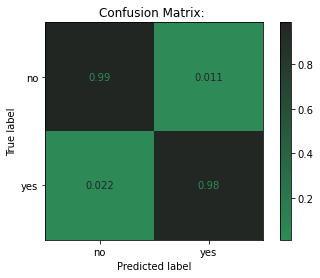

              precision    recall  f1-score   support

          no       0.99      0.99      0.99     36490
         yes       0.98      0.98      0.98     18770

    accuracy                           0.99     55260
   macro avg       0.98      0.98      0.98     55260
weighted avg       0.99      0.99      0.99     55260




In [137]:
h.plot_classifier_scores(xgb_loans_1, X_val, y_val, y_hat_val_xgb, labels)

Actually XGBClassifier is doing very well, we got almost perfect recall and precision of both. Let's see miss classifications:

In [138]:
missed_1_xgb = X_val[(y_val == 1) & (y_hat_val_xgb == 0)]
missed_1_xgb.shape

(406, 13)

In [139]:
missed_1_xgb[:5]

,loan_amnt,purpose,fico_score,dti,addr_state,emp_length,year,month,cos_month,sin_month,log_loan_amnt,log_fico_score,log_dti
647260,20000.00,debt_consolidation,727.00,5.96,IL,0,2018,1,0.87,0.50,9.90,6.59,1.79
1073116,6000.00,debt_consolidation,672.00,24.03,WI,0,2018,10,0.50,-0.87,8.70,6.51,3.18
66306,15000.00,other,772.00,3.97,CA,0,2018,12,1.00,-0.00,9.62,6.65,1.38
622710,8000.00,debt_consolidation,697.00,37.97,CA,0,2018,10,0.50,-0.87,8.99,6.55,3.64
929045,10000.00,small_business,742.00,31.33,GA,0,2018,10,0.50,-0.87,9.21,6.61,3.44


In [140]:
missed_0_xgb = X_val[(y_val == 0) & (y_hat_val_xgb == 1)]
missed_0_xgb.shape

(401, 13)

In [141]:
missed_0_xgb[:5]

,loan_amnt,purpose,fico_score,dti,addr_state,emp_length,year,month,cos_month,sin_month,log_loan_amnt,log_fico_score,log_dti
570007,30000.00,debt_consolidation,722.00,4.94,KY,6,2018,1,0.87,0.50,10.31,6.58,1.60
1041618,20000.00,major_purchase,707.00,46.66,KS,10,2018,1,0.87,0.50,9.90,6.56,3.84
557262,20000.00,debt_consolidation,697.00,21.82,OK,0,2018,10,0.50,-0.87,9.90,6.55,3.08
345421,27000.00,moving,717.00,26.59,AL,0,2018,6,-1.00,0.00,10.20,6.58,3.28
84967,22000.00,debt_consolidation,662.00,25.72,MD,0,2018,1,0.87,0.50,10.00,6.50,3.25


Seems that module miss classified "1" because of emp_length, that was < 1 year and dti, that was quite high too. And "0" were miss classified because of quite high fico score.

* Let's see which features were mostly important.

In [143]:
feature_names = h.feature_names(xgb_loans_1, numeric_features, binary_features, one_hot_features)

Text(0.5, 1.0, 'Feature importance in XGBClassifier by weight')

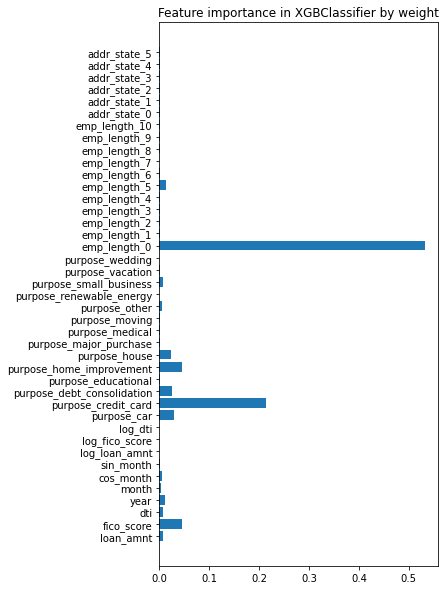

In [35]:
values = xgb_loans_1.named_steps["classifier"].feature_importances_
plt.figure(figsize=(5, 10))
plt.barh(feature_names, values)
plt.title("Feature importance in XGBClassifier by weight")

So seems that most important features by weight were: empl_length (<1 year, 5+ year), purpose - small business, house, home_improvement, debt consolidation, credit card, car, year, dti, fico score and loan amnt. By one-hot encoding a categorical variable, we are inducing sparsity into the dataset which is undesirable.
From the splitting algorithm’s point of view, all the dummy variables are independent. If the tree decides to make a split on one of the dummy variables, the gain in purity per split is very marginal. As a result, the tree is very unlikely to select one of the dummy variables closer to the root.

## 2.3.2. XGB classifier, without scaling, sin and cos of months and with Ordinal encoding only.

In [51]:
# Let's drop some columns from training, validation data.
X_train_under_less = X_train_under.drop(columns=["cos_month","sin_month",	"log_loan_amnt", "log_fico_score",	"log_dti"])
X_val_less = X_val.drop(columns=["cos_month", "sin_month",	"log_loan_amnt", "log_fico_score",	"log_dti"])
X_test_less = X_test.drop(columns=["cos_month", "sin_month",	"log_loan_amnt", "log_fico_score",	"log_dti"])


In [52]:
ordinal_features = ["purpose", "addr_state"]

In [53]:
ordinal_transformer = Pipeline(
    steps=[("ordinal_encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ("ordinal", ordinal_transformer, ordinal_features),
    ],
    remainder="passthrough",
)

In [ ]:
xgb_loans_2 = Pipeline(
    steps=[
        ("preprocessor2", preprocessor2),
        ("classifier", XGBClassifier(random_state=123, use_label_encoder=False)),
    ]
).fit(X_train_under_less, y_train_under)

y_hat_train_xgb2 = xgb_loans_2.predict(X_train_under_less)
y_hat_val_xgb2 = xgb_loans_2.predict(X_val_less)

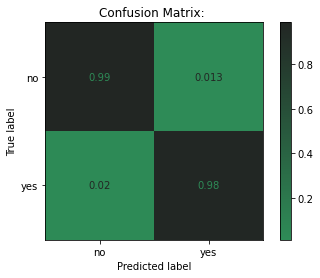

              precision    recall  f1-score   support

          no       0.99      0.99      0.99     36490
         yes       0.98      0.98      0.98     18770

    accuracy                           0.98     55260
   macro avg       0.98      0.98      0.98     55260
weighted avg       0.98      0.98      0.98     55260




In [149]:
h.plot_classifier_scores(xgb_loans_2, X_val_less, y_val, y_hat_val_xgb2, labels)

* Let's see what features this time were most important.

In [ ]:
X_train_under_less.columns.to_list()

Text(0.5, 1.0, 'Feature importance in XGBClassifier by weight')

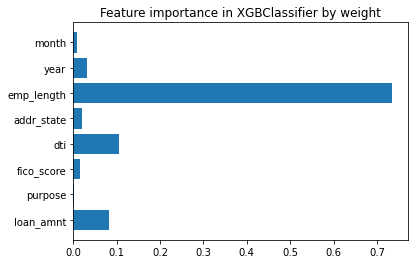

In [45]:
xgb_loans_2.named_steps["classifier"].feature_importances_
features = X_train_under_less.columns.to_list()
values = xgb_loans_2.named_steps["classifier"].feature_importances_
plt.barh(features, values)
plt.title("Feature importance in XGBClassifier by weight")

Actually now we see a much more clear view, that with the same main features, no one_hot_encoding, we got that the most important features were employment length, the debt to income ratio, loan amount, and whats the most surprising - purpose wasn't at all important. That shows that dummy variables are actually affecting tree based models and changes the important of features (gives more importance to those synthetically made (dummy) larger number of features).

* Let's try to tune this model.

## 2.3.3. XGB classifier hyperparameter tuning, probability threshold search, SHAP values

In [ ]:
study = optuna.create_study(direction="maximize", study_name="XGBClassifier")
func = lambda trial: h.xgb_objective(trial, X_train_under_less, pd.DataFrame(y_train_under), preprocessor2)
study.optimize(func, n_trials=10)

In [48]:
trial = study.best_trial
xgb_params = trial.params

In [49]:
for key, value in xgb_params.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value (ROC AUC): {study.best_value:.5f}')


		n_estimators: 529
		learning_rate: 0.27472048792575454
		num_leaves: 2900
		max_depth: 12
		reg_alpha: 0.06902792041884684
		reg_lambda: 56.71862221951366
		gama: 7.042934590103538
		min_child_weight: 8
		scale_pos_weight: 12
	Best value (f1): 0.98281


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
xgb_loans_tuned_3 = Pipeline(
    steps=[
        ("preprocessor", preprocessor2),
        ("classifier", XGBClassifier(n_estimators=529,
		learning_rate=0.27472048792575454,
		num_leaves=2900,
		max_depth=12,
		reg_alpha=0.06902792041884684,
		reg_lambda=56.71862221951366,
		gama=7.042934590103538,
		min_child_weight=8,
		scale_pos_weight=12, use_label_encoder=False, random_state=123)),
    ]
)

scores = cross_val_score(
    xgb_loans_tuned_3, X_train_under_less, y_train_under, cv=cv, scoring="f1_macro"
)

In [68]:
print(f"XGBoost classifier F1 score on train data: {scores.mean()}")

XGBoost classifier F1 score on train data: 0.9829166681470113


In [ ]:
xgb_loans_tuned_3.fit(X_train_under_less, y_train_under)

In [70]:
y_hat_val_xgb_tuned_3 = xgb_loans_tuned_3.predict(X_val_less)
y_hat_test_xgb_tuned_3 = xgb_loans_tuned_3.predict(X_test_less)

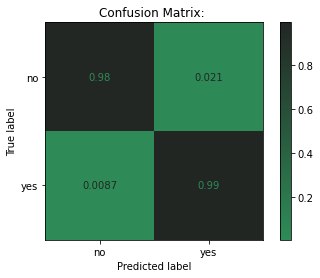

              precision    recall  f1-score   support

          no       1.00      0.98      0.99     36490
         yes       0.96      0.99      0.98     18770

    accuracy                           0.98     55260
   macro avg       0.98      0.98      0.98     55260
weighted avg       0.98      0.98      0.98     55260




In [73]:
h.plot_classifier_scores(xgb_loans_tuned_3, X_val_less, y_val, y_hat_val_xgb_tuned_3, labels)


We have a little higher False positive rate after tuning (from 0.013 to 0.021, that's why the precision of "yes" dropped from 98 to 96), on the other hand we have lower False negative rate from 0.02 to 0.0087. But the number are very close.

* Finding  the best threshold using PR curve and trying the threshold tuning:

Best Threshold: 0.7508000135421753 with F-Score: 0.977
Recall: 0.9842, Precision: 0.97


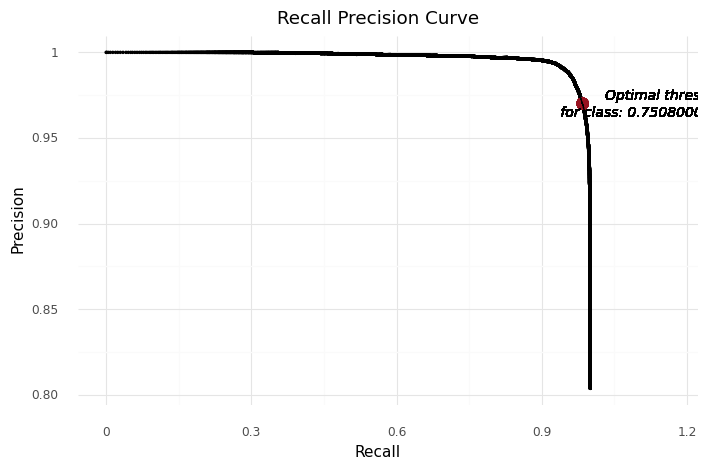

<ggplot: (163542411945)>

In [162]:
h.precision_recall_curve_opt_threshold(xgb_loans_tuned_3, X_val_less)

* Threshold tuning.

Length of sequence: 10000
Best Threshold: 0.7499 with F-Score: 0.977


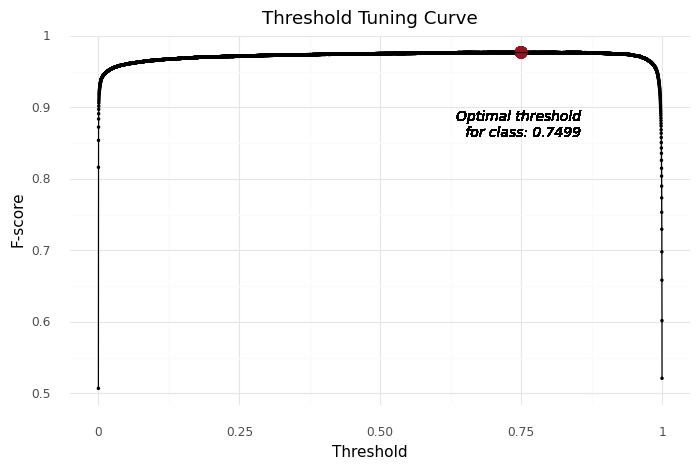

<ggplot: (163434557769)>

In [169]:
h.prob_trheshold_tuning(xgb_loans_tuned_3, X_val_less, y_val)

So, according to these metrics, the best probability threshold would be not 0.5 (like default), but 0.7499, in that way  we would get better F1 score and more values actually would be defined as "0", not "1", we would loose some Type 1 errors.

* Now let's see if we set the probability threshold as suggested to 0.75, what would we get in the test set.

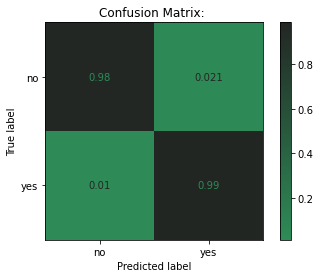

              precision    recall  f1-score   support

          no       0.99      0.98      0.99     36664
         yes       0.97      0.98      0.98     18596

    accuracy                           0.98     55260
   macro avg       0.98      0.98      0.98     55260
weighted avg       0.98      0.98      0.98     55260




In [145]:
y_hat_test_xgb_tuned_3_threshold = (xgb_loans_tuned_3.predict_proba(X_test_less)[:,1] >= 0.75).astype(bool)
h.plot_classifier_scores(xgb_loans_tuned_3, X_test_less, y_test, y_hat_test_xgb_tuned_3_threshold, labels)

In [79]:
missed_xgb3 = X_test_less[(y_test == 1) & (y_hat_test_xgb_tuned_3_threshold == 0)]
missed_xgb3.shape

(328, 8)

In [81]:
missed_xgb3[:5]

,loan_amnt,purpose,fico_score,dti,addr_state,emp_length,year,month
1022208,20000.00,other,677.00,3.47,PA,0,2018,3
40065,40000.00,debt_consolidation,682.00,34.80,CA,0,2018,2
860430,20000.00,car,697.00,19.11,NY,2,2018,10
723020,30000.00,debt_consolidation,682.00,28.80,TX,0,2018,9
455614,10000.00,debt_consolidation,662.00,16.71,MD,0,2018,8


In [83]:
missed_xgb3_0 = X_test_less[(y_test == 0) & (y_hat_test_xgb_tuned_3_threshold == 1)]
missed_xgb3_0.shape

(552, 8)

Seems that this threshold tuning helped to reduce False positives, but a little bit enlarged false negatives.

* SHAP Values:

In [148]:
xgb_explainer = shap.TreeExplainer(xgb_loans_tuned_3["classifier"])
xgb_shap_values = xgb_explainer(preprocessor2.transform(X_val_less))

c:\Users\ikirs\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [149]:
features_less = X_train_under_less.columns.tolist()

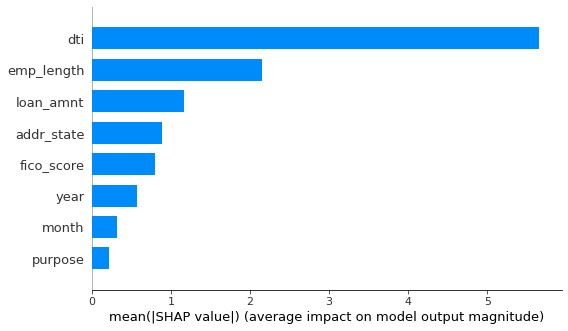

In [151]:
shap.summary_plot(xgb_shap_values, feature_names=features_less, plot_type="bar")

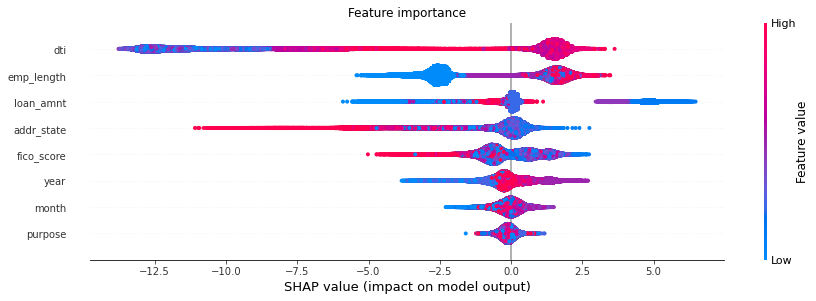

In [154]:
X_val_tr = preprocessor2.transform(X_val_less)
shap.summary_plot(
    xgb_shap_values,
    X_val_tr,
    feature_names=features_less,
    max_display=10,
    show=False,
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 4)
ax.set_title("Feature importance", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)

So it can be concluded that in the tuned XGB Classifier the most of the impact to the final decision had values: dti, emp_length, addr_state and fico_score (but very individually, as for some cases the same feature could have increased the final probability towards "1" and in other cases decrease, that's because the feature correlates with each other too).

## 2.3.4. XGB classifier with less features (according to SHAP values)

So I decided to try only with these features from SHAP values: dti, emp_length, loan_amnt, addr_state and fico_score.

In [172]:
X_train_under_less_shap = X_train_under_less.drop(columns=["year", "month", "purpose"])
X_val_less_shap = X_val_less.drop(columns=["year", "month", "purpose"])
X_test_less_shap = X_test_less.drop(columns=["year", "month", "purpose"])

In [174]:
ordinal_feature = ["addr_state"]
ordinal_transformer = Pipeline(
    steps=[("ordinal_encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]
)

preprocessor3 = ColumnTransformer(
    transformers=[
        ("ordinal", ordinal_transformer, ordinal_feature),
    ],
    remainder="passthrough",
)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
xgb_loans_tuned_4 = Pipeline(
    steps=[
        ("preprocessor", preprocessor3),
        ("classifier", XGBClassifier(**xgb_params, use_label_encoder=False)),
    ]
)

scores = cross_val_score(
    xgb_loans_tuned_4, X_train_under_less_shap, y_train_under, cv=cv, scoring="f1_macro"
)

In [75]:
print(f"XGBoost classifier (less features by shap) F1 score on train data: {scores.mean()}")

XGBoost classifier (less features by shap) F1 score on train data: 0.9772996335760851


In [ ]:
xgb_loans_tuned_4.fit(X_train_under_less_shap, y_train_under)
y_hat_test_xgb_tuned_4 = xgb_loans_tuned_4.predict(X_test_less_shap)

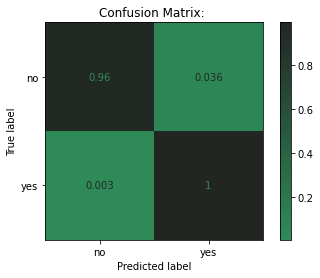

              precision    recall  f1-score   support

          no       1.00      0.96      0.98     36664
         yes       0.93      1.00      0.96     18596

    accuracy                           0.98     55260
   macro avg       0.97      0.98      0.97     55260
weighted avg       0.98      0.98      0.98     55260




In [166]:
h.plot_classifier_scores(xgb_loans_tuned_4, X_test_less, y_test, y_hat_test_xgb_tuned_4, labels)


We got the recall of "1" 100 % accurate, but reduced the precision to 93 percent. Enlarged the False positives rate.

Text(0.5, 1.0, 'Precision-Recall curve')

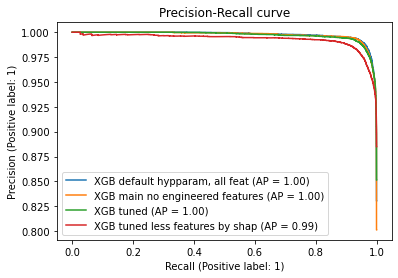

In [84]:
plot_precision_recall_curve(xgb_loans_1, X_test, y_test, ax = plt.gca(),name = "XGB default hypparam, all feat")
plot_precision_recall_curve(xgb_loans_2, X_test_less, y_test, ax = plt.gca(),name = "XGB main no engineered features")
plot_precision_recall_curve(xgb_loans_tuned_3, X_test_less, y_test, ax = plt.gca(),name = "XGB tuned")
plot_precision_recall_curve(xgb_loans_tuned_4, X_test_less_shap, y_test, ax = plt.gca(),name = "XGB tuned less features by shap")
plt.title('Precision-Recall curve')

All in all all XGB models work very similar, but less and more simple features I think is an advantage, so I picked to save tuned XGBClassifier - xgb_loans_tuned_3.

In [74]:
# filename = "model_xgb_loans.joblib"
# dump(xgb_loans_tuned_3, filename)

['model_xgb_loans.joblib']

## 2.4. LGBM Classifier

## 2.4.1. LGBM classifier with engineered features and default hyperparameters

In [178]:
lgbm_loans_1 = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LGBMClassifier()),
    ]
)

scores = cross_val_score(
lgbm_loans_1, X_train_under, y_train_under, cv=cv, scoring="f1_macro"
)

In [179]:
print(f"LGBM classifier F1 score on train data: {scores.mean()}")

LGBM classifier F1 score on train data: 0.9825220791313564


In [ ]:
lgbm_loans_1.fit(X_train_under, y_train_under)

In [181]:
y_hat_train_lgbm = lgbm_loans_1.predict(X_train_under)
y_hat_val_lgbm = lgbm_loans_1.predict(X_val)

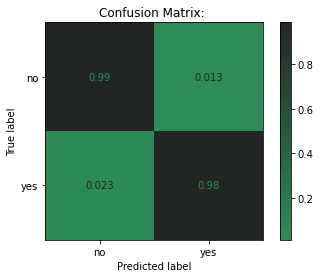

              precision    recall  f1-score   support

          no       0.99      0.99      0.99     36490
         yes       0.97      0.98      0.98     18770

    accuracy                           0.98     55260
   macro avg       0.98      0.98      0.98     55260
weighted avg       0.98      0.98      0.98     55260




In [182]:
h.plot_classifier_scores(lgbm_loans_1, X_val, y_val, y_hat_val_lgbm, labels)

Text(0.5, 1.0, 'Precision-Recall curve')

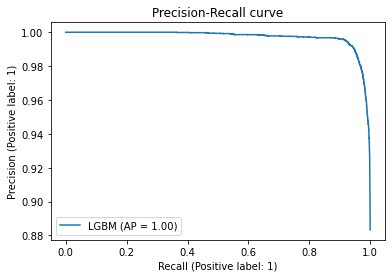

In [92]:
plot_precision_recall_curve(lgbm_loans_1, X_val, y_val, ax = plt.gca(),name = "LGBM")

plt.title('Precision-Recall curve')

results are very similar to the XGBClassifier.

## 2.4.2. LGBM classifier with main features and default hyperparameters

In [183]:
lgbm_loans_2 = Pipeline(
    steps=[
        ("preprocessor", preprocessor2),
        ("classifier", LGBMClassifier()),
    ]
)

scores = cross_val_score(
lgbm_loans_2, X_train_under_less, y_train_under, cv=cv, scoring="f1_macro"
)

In [184]:
print(f"LGBM classifier with main features F1 score on train data: {scores.mean()}")

LGBM classifier with main features F1 score on train data: 0.9826889337988935


In [ ]:
lgbm_loans_2.fit(X_train_under_less, y_train_under)

In [186]:
y_hat_train_lgbm2 = lgbm_loans_2.predict(X_train_under_less)
y_hat_val_lgbm2 = lgbm_loans_2.predict(X_val_less)

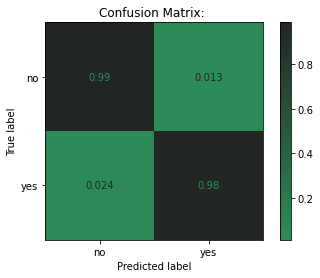

              precision    recall  f1-score   support

          no       0.99      0.99      0.99     36490
         yes       0.97      0.98      0.97     18770

    accuracy                           0.98     55260
   macro avg       0.98      0.98      0.98     55260
weighted avg       0.98      0.98      0.98     55260




In [187]:
h.plot_classifier_scores(lgbm_loans_2, X_val_less, y_val, y_hat_val_lgbm2, labels)

Just a little bit worse (the precision of "yes" dropped).

## 2.4.3. LGBM classifier hyperparameter tuning, SHAP values

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBMClassifier")
func = lambda trial: h.lgbm_objective(trial, X_train_under_less, y_train_under, preprocessor2)
study.optimize(func, n_trials=20)

In [100]:
trial = study.best_trial
lgbm_params = trial.params

In [101]:
for key, value in lgbm_params.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value (f1): {study.best_value:.5f}')


		n_estimators: 151
		learning_rate: 0.29015572616949065
		num_leaves: 1140
		max_depth: 9
		min_data_in_leaf: 400
		lambda_l1: 0
		lambda_l2: 100
		min_gain_to_split: 4.52528026847952
	Best value (f1): 0.48388


In [ ]:
lgbm_loans_tuned_3= Pipeline(
    steps=[
        ("preprocessor", preprocessor2),
        ("classifier", LGBMClassifier(**lgbm_params)),
    ]
)

scores = cross_val_score(
    lgbm_loans_tuned_3, X_train_under_less, y_train_under, cv=cv, scoring="f1_macro"
)

In [103]:
print(f"LGBM classifier tuned F1 score on train data: {scores.mean()}")

LGBM classifier tuned F1 score on train data: 0.9792770267063478


In [ ]:
lgbm_loans_tuned_3.fit(X_train_under_less, y_train_under)

In [105]:
y_hat_val_lgbm3 = lgbm_loans_tuned_3.predict(X_val_less)

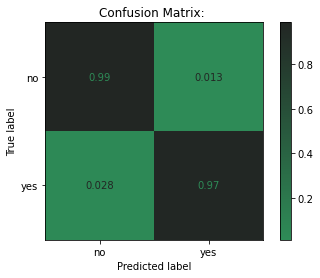

              precision    recall  f1-score   support

          no       0.99      0.99      0.99     36490
         yes       0.97      0.97      0.97     18770

    accuracy                           0.98     55260
   macro avg       0.98      0.98      0.98     55260
weighted avg       0.98      0.98      0.98     55260




In [106]:
h.plot_classifier_scores(lgbm_loans_tuned_3, X_val_less, y_val, y_hat_val_lgbm3, labels)


I got lower recall and precision of F1 score of "1", let's see the are under the precision recall curve.

Text(0.5, 1.0, 'Precision-Recall curve')

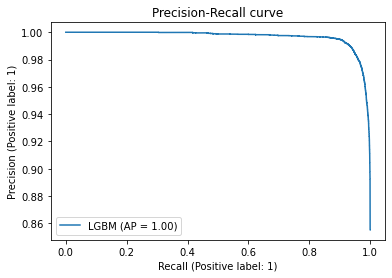

In [108]:
plot_precision_recall_curve(lgbm_loans_tuned_3, X_val_less, y_val, ax = plt.gca(),name = "LGBM")

plt.title("Precision-Recall curve")

* SHAP values:

In [111]:
features_less = X_train_under_less.columns.to_list()

In [109]:
lgbm_explainer = shap.TreeExplainer(lgbm_loans_tuned_3["classifier"])
lgbm_shap_values = lgbm_explainer(preprocessor2.transform(X_val_less))

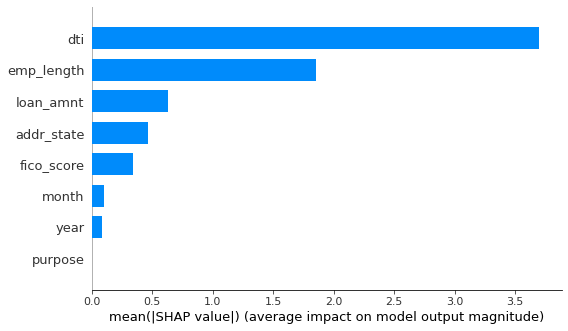

In [141]:
shap.summary_plot(lgbm_shap_values[:, :, -1], feature_names=features_less, plot_type="bar")

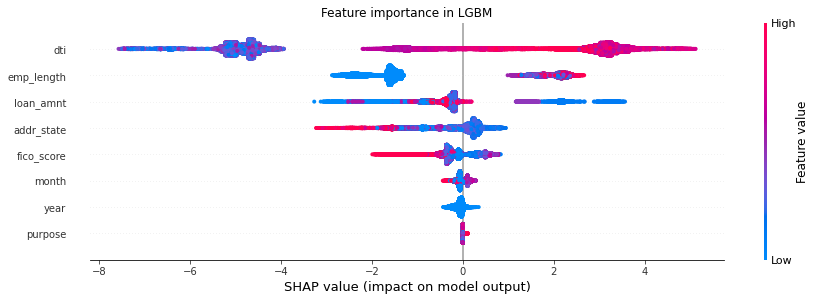

In [142]:
X_val_tr = preprocessor2.transform(X_val_less)
shap.summary_plot(
    lgbm_shap_values[:, :, -1],
    X_val_tr,
    feature_names=features_less,
    max_display=10,
    show=False,
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 4)
ax.set_title("Feature importance in LGBM", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)

So actually the same features like in XGBOOST seems the most important in the LGBM too: dti, emp_length, loan_amnt, addr_state and fico_score.

# 3. Grade prediction

## 3.1. Feature pre-processing

I decided to:
1. separate all data from 2018, take a sample of it, make it the validation and test data.
2. train data - first option: data from year 2013 to 2017 (including), under sample this data, to have equal amount of all grade groups.
            - second option: all data from the year 2013-2017 for training.

In [65]:
accepted_loans_df = (accepted_loans_df
    .pipe(h.months_sin_cos, "month")
    .pipe(h.log_feature, "loan_amnt")
    .pipe(h.log_feature, "annual_inc")
    .pipe(h.log_feature, "avg_cur_bal")
    .pipe(h.log_feature, "dti")
    .pipe(h.log_feature, "fico_score")
    .pipe(h.log_feature, "last_fico_score")
)

In [66]:
# Separating the year 2018.
val_acc_data_2018 = accepted_loans_df[accepted_loans_df["year"] ==2018]
train_acc_data = accepted_loans_df[accepted_loans_df["year"] != 2018]

In [106]:
# Saved the data, that I'll use for further model training.
# train_acc_data.to_csv("accepted_2013_2017_training.csv", index=False)

In [107]:
# Saved the data, that I'll use for further model validation from year 2018.
# val_acc_data_2018.to_csv("accepted_2018_validation.csv", index=False)

* Train data, under sampling.

In [67]:
train_acc_data = pd.read_csv("accepted_2013_2017_training.csv")
val_acc_data_2018 = pd.read_csv("accepted_2018_validation.csv")

In [68]:
X_grade_train = train_acc_data.drop(columns=["grade", "sub_grade", "int_rate", "status"], axis=1)
y_grade_train = train_acc_data.grade

In [69]:
Counter(y_grade_train)

Counter({2: 148204, 1: 152848, 5: 5601, 0: 97247, 3: 56463, 4: 19925, 6: 2025})

In [70]:
undersampler_grade = RandomUnderSampler(sampling_strategy="all", random_state=123)
# fit and apply the transform
X_grade_train_under, y_grade_train_under = undersampler_grade.fit_resample(X_grade_train, y_grade_train)
# summarize class distribution
print(Counter(y_grade_train_under))

Counter({0: 2025, 1: 2025, 2: 2025, 3: 2025, 4: 2025, 5: 2025, 6: 2025})


* Validation data.

In [71]:
sample_2018_loans = val_acc_data_2018.sample(frac=0.05)

In [72]:
X_grade_remain = sample_2018_loans.drop(columns=["grade", "sub_grade", "int_rate", "status"], axis=1)
y_grade_remain = sample_2018_loans.grade
X_grade_val, X_grade_test, y_grade_val, y_grade_test = train_test_split(
    X_grade_remain, y_grade_remain, test_size=0.5, random_state=123
)

In [74]:
# emp_length - passthrough
numeric_acc_features = [
    "loan_amnt",
    "annual_inc",
    "dti",
   	"delinq_2yrs",
    "inq_last_6mths",
    "open_acc",	
    "pub_rec",
    "total_acc",
    "inq_last_12m",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "mo_sin_old_il_acct",
    "mort_acc",
    "pct_tl_nvr_dlq",
    "pub_rec_bankruptcies",
    "fico_score",
    "last_fico_score",
    "month",
    "year",	
    "earliest_cr_line_year",
    "cos_month",
    "sin_month",
    "log_loan_amnt",
    "log_annual_inc",
    "log_avg_cur_bal",
    "log_dti",
    "log_fico_score",
    "log_last_fico_score"
]

ordinal_acc_features = ["application_type", "term"]
one_hot_acc_features = ["home_ownership", "purpose", "emp_title"]
binary_acc_features = ["addr_state"]

In [75]:
one_hot_transformer = Pipeline(
    steps=[("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

binary_transformer = Pipeline(
    steps=[("binary_encoder", ce.BinaryEncoder(cols=binary_acc_features))]
)

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

ordinal_transformer = Pipeline(
    steps=[
        (
            "ordinal_encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        )
    ]
)

preprocessor_acc = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_acc_features,),
        ("one_hot", one_hot_transformer, one_hot_acc_features),
        ("binary", binary_transformer, binary_acc_features),
        ("ordinal", ordinal_transformer, ordinal_acc_features),
    ],
    remainder="passthrough",
)

In [ ]:
# base_line_grade = h.base_line_multi(X_grade_train_under, y_grade_train_under, preprocessor_acc)

In [200]:
# base_line_grade

,Balanced accuracy,Accuracy,Recall,Precision,f1,Fit_time
Logistic regression,0.380176,0.380176,0.380176,0.365233,0.369053,15.997499
SVC,0.381799,0.381799,0.381799,0.370132,0.373868,3.765282
XGB classifier,0.366702,0.366702,0.366702,0.356926,0.361055,4.999987
LGBM classifier,0.374956,0.374956,0.374956,0.361409,0.366433,1.152572


Scores doesn't look so good, but actually almost the same were with the largest imbalanced training data set and it took ages for my machine to procede this task, so I'll keep this one smaller for further development with SVMClassifier.

## 3.2. SVM Classifier

* No hyperparameter tuning.

In [ ]:
svc_grade = Pipeline(
    steps=[
        ("preprocessor", preprocessor_acc),
        (
            "classifier",
            SVC(probability=True, class_weight="balanced", random_state=123),
        ),
    ]
)

svc_grade.fit(X_grade_train_under, y_grade_train_under)

In [203]:
y_hat_train_svc = svc_grade.predict(X_grade_train_under)
y_hat_val_svc = svc_grade.predict(X_grade_val)

In [16]:
labels_grade = ["A", "B", "C", "D", "E", "F", "G"]

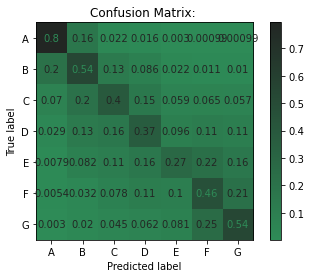

              precision    recall  f1-score   support

           A       0.71      0.80      0.75      2025
           B       0.46      0.54      0.50      2025
           C       0.42      0.40      0.41      2025
           D       0.39      0.37      0.38      2025
           E       0.43      0.27      0.33      2025
           F       0.41      0.46      0.43      2025
           G       0.50      0.54      0.52      2025

    accuracy                           0.48     14175
   macro avg       0.48      0.48      0.47     14175
weighted avg       0.48      0.48      0.47     14175




In [205]:
h.plot_classifier_scores(svc_grade, X_grade_train_under, y_grade_train_under, y_hat_train_svc, labels_grade)

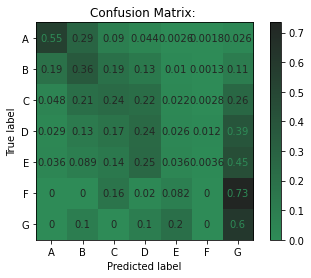

              precision    recall  f1-score   support

           A       0.69      0.55      0.61      2277
           B       0.41      0.36      0.39      2226
           C       0.33      0.24      0.28      1793
           D       0.22      0.24      0.23      1006
           E       0.09      0.04      0.05       280
           F       0.00      0.00      0.00        49
           G       0.00      0.60      0.01        10

    accuracy                           0.36      7641
   macro avg       0.25      0.29      0.22      7641
weighted avg       0.44      0.36      0.39      7641




In [206]:
h.plot_classifier_scores(svc_grade, X_grade_val, y_grade_val, y_hat_val_svc, labels_grade)

Looks like over fitting, as the scores from training to validation data had dropped drastically. It predicts larger classes (in validation set better than smallest ones).

* SVC hyperparameter tuning.

In [ ]:
study = optuna.create_study(direction="maximize", study_name="SVC_PCA") 
func = lambda trial: h.SVC_objective(trial, X_grade_train_under, y_grade_train_under, preprocessor_acc)
study.optimize(func, n_trials=20)

In [18]:
trial = study.best_trial
pca_SVC = study.best_trial.params
for key, value in pca_SVC.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value (f1): {study.best_value:.5f}')


		dim_red: None
		svc_C: 0.8261388101824684
		svc_kernel: linear
		svc_gamma: 0.37357680202203436
		svc_class_weight: None
	Best value (f1): 0.36595


In [ ]:
svc_grade_2 = Pipeline(
    steps=[
        ("preprocessor", preprocessor_acc),
        (
            "classifier",
            SVC(
                C=0.8261388101824684,
                kernel="linear",
                gamma=0.37357680202203436,
                probability=True,
                class_weight="balanced",
                random_state=123,
            ),
        ),
    ]
)

svc_grade_2.fit(X_grade_train_under, y_grade_train_under)

In [14]:
y_hat_train_svc2 = svc_grade_2.predict(X_grade_train_under)
y_hat_val_svc2 = svc_grade_2.predict(X_grade_val)

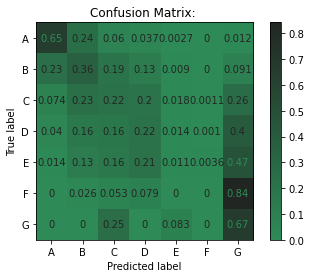

              precision    recall  f1-score   support

           A       0.68      0.65      0.67      2258
           B       0.41      0.36      0.38      2234
           C       0.35      0.22      0.27      1852
           D       0.21      0.22      0.22       971
           E       0.04      0.01      0.02       276
           F       0.00      0.00      0.00        38
           G       0.01      0.67      0.01        12

    accuracy                           0.38      7641
   macro avg       0.24      0.30      0.22      7641
weighted avg       0.43      0.38      0.40      7641




In [17]:
h.plot_classifier_scores(svc_grade_2, X_grade_val, y_grade_val, y_hat_val_svc2, labels_grade)

So, actually it improved a little bit, no PCA() was recommended by the optuna. Again grade "A" and "G" were predicted more accurate.

* Permutation importance.

In [21]:
feature_names_grade = h.feature_names_num_hot_bin_ord(
    svc_grade_2,
    numeric_acc_features,
    binary_acc_features,
    one_hot_acc_features,
    ordinal_acc_features,
)

Text(0.5, 0, 'Permutation Importance')

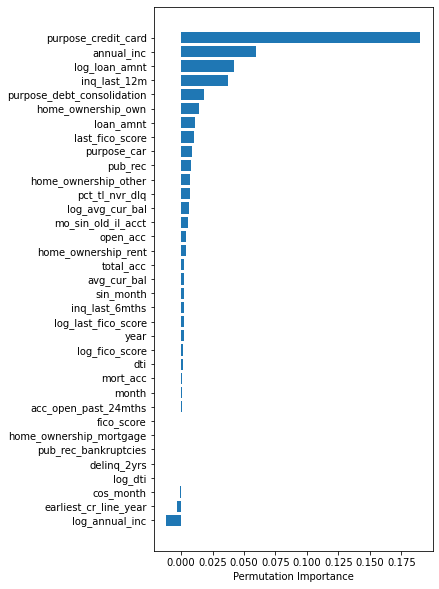

In [20]:
perm_importance = permutation_importance(
    svc_grade_2, X_grade_val, y_grade_val, n_repeats=10, random_state=123
)

features = np.array(feature_names_grade)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(5, 10))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

So by permutation importance "test" most valuable features for the final result were: purpose: credit_card, annual income, log_loan_amnt, inq_last_12_months, purpose_debt_consolidation. 

* So, this doesn't satisfy me, and if I try to use all training data and all features with encoded ones, the number of features will be enormous. I decided to try another approach - XGBClassifier (as it did very good on the loan prediction and some of the same data actually and doesn't need scaling, and Ordinal encoding is enough).

## 3.3. XGB Classifier

### 3.3.1. XGBClassifier on not engineered features with default hyperparameters

So it reduces dimensionality in another way, I will use tree based model, so I don't need scaling and engineered features(cos/sin months and log version of numeric values), also one_hot_encoding, binary encoding, all categorical features can be encoded with Ordinal encoder, so I'll use the smaller easier dataset with pipeline.

In [76]:
X_grade_train_under_xgb = X_grade_train_under.drop(
    columns=[
    "cos_month",
    "sin_month",
    "log_loan_amnt",
    "log_annual_inc",
    "log_avg_cur_bal",
    "log_dti",
    "log_fico_score",
    "log_last_fico_score"
    ]
)

X_grade_val_xgb = X_grade_val.drop(
    columns=[
    "cos_month",
    "sin_month",
    "log_loan_amnt",
    "log_annual_inc",
    "log_avg_cur_bal",
    "log_dti",
    "log_fico_score",
    "log_last_fico_score"
    ]
)
X_grade_test_xgb = X_grade_test.drop(
    columns=[
    "cos_month",
    "sin_month",
    "log_loan_amnt",
    "log_annual_inc",
    "log_avg_cur_bal",
    "log_dti",
    "log_fico_score",
    "log_last_fico_score"
    ]
)

In [77]:
ordinal_acc_features_xgb = ["application_type", "home_ownership", "purpose", "emp_title", "addr_state", "term"]

In [78]:
ordinal_transformer_xgb = Pipeline(
    steps=[
        (
            "ordinal_encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        )
    ]
)

preprocessor_acc_xgb = ColumnTransformer(
    transformers=[("ordinal", ordinal_transformer_xgb, ordinal_acc_features_xgb)],
    remainder="passthrough",
)

In [25]:
xgb_grade_1 = Pipeline(
    steps=[
        ("preprocessor_xgb", preprocessor_acc_xgb),
        ("classifier", XGBClassifier(random_state=123, use_label_encoder=False)),
    ]
).fit(X_grade_train_under_xgb, y_grade_train_under)

y_hat_train_grade = xgb_grade_1.predict(X_grade_train_under_xgb)
y_hat_val_grade = xgb_grade_1.predict(X_grade_val_xgb)

[14:23:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


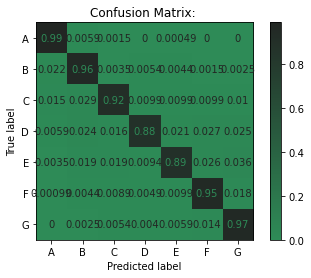

              precision    recall  f1-score   support

           A       0.95      0.99      0.97      2025
           B       0.92      0.96      0.94      2025
           C       0.94      0.92      0.93      2025
           D       0.96      0.88      0.92      2025
           E       0.95      0.89      0.92      2025
           F       0.92      0.95      0.94      2025
           G       0.91      0.97      0.94      2025

    accuracy                           0.94     14175
   macro avg       0.94      0.94      0.94     14175
weighted avg       0.94      0.94      0.94     14175




In [26]:
h.plot_classifier_scores(xgb_grade_1,X_grade_train_under_xgb, y_grade_train_under, y_hat_train_grade, labels_grade)

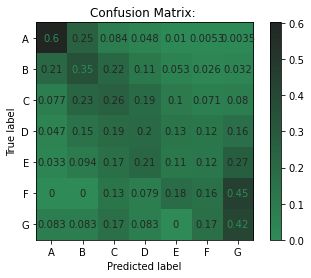

              precision    recall  f1-score   support

           A       0.67      0.60      0.64      2258
           B       0.40      0.35      0.37      2234
           C       0.34      0.26      0.29      1852
           D       0.20      0.20      0.20       971
           E       0.06      0.11      0.08       276
           F       0.02      0.16      0.03        38
           G       0.01      0.42      0.02        12

    accuracy                           0.37      7641
   macro avg       0.24      0.30      0.23      7641
weighted avg       0.43      0.37      0.40      7641




In [28]:
h.plot_classifier_scores(xgb_grade_1,X_grade_val_xgb, y_grade_val, y_hat_val_grade, labels_grade)

Seems like actual over fitting, the model just remembers the data, not generalizes. As we see this model could predict better the highest and the lowest grade. 

* Let's try to tune, would it help to overcome over fitting.

In [ ]:
study = optuna.create_study(direction="maximize", study_name="XGBmulti")
func = lambda trial: h.xgb_objective_multi(trial, X_grade_train_under_xgb, y_grade_train_under, preprocessor_acc_xgb)
study.optimize(func, n_trials=20)

In [70]:
trial = study.best_trial
xgb_params_grade = trial.params

In [71]:
for key, value in xgb_params_grade.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value (f1): {study.best_value:.5f}')


		n_estimators: 345
		learning_rate: 0.23810052612348334
		num_leaves: 1800
		max_depth: 3
		reg_alpha: 0.2686870661610261
		reg_lambda: 14.681286151767107
	Best value (f1): 0.37462


In [ ]:
xgb_grade_2 = Pipeline(
    steps=[
        ("preprocessorxgb", preprocessor_acc_xgb),
        ("classifier", XGBClassifier(**xgb_params_grade, random_state=123, use_label_encoder=False)),
    ]
).fit(X_grade_train_under_xgb, y_grade_train_under)

y_hat_train_grade2 = xgb_grade_2.predict(X_grade_train_under_xgb)
y_hat_val_grade2 = xgb_grade_2.predict(X_grade_val_xgb)

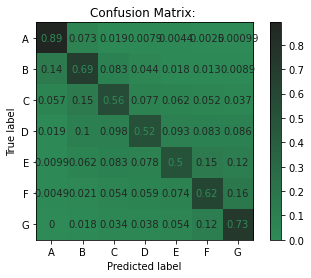

              precision    recall  f1-score   support

           A       0.95      0.99      0.97      2025
           B       0.92      0.96      0.94      2025
           C       0.94      0.92      0.93      2025
           D       0.96      0.88      0.92      2025
           E       0.95      0.89      0.92      2025
           F       0.92      0.95      0.94      2025
           G       0.91      0.97      0.94      2025

    accuracy                           0.94     14175
   macro avg       0.94      0.94      0.94     14175
weighted avg       0.94      0.94      0.94     14175




In [73]:
h.plot_classifier_scores(xgb_grade_2,X_grade_train_under_xgb, y_grade_train_under, y_hat_train_grade, labels_grade)

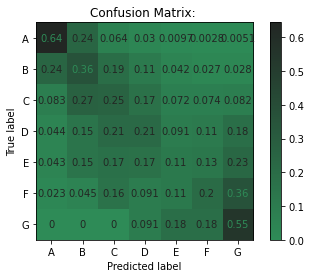

              precision    recall  f1-score   support

           A       0.66      0.62      0.64      2164
           B       0.37      0.32      0.35      2133
           C       0.35      0.26      0.30      1957
           D       0.22      0.21      0.21      1033
           E       0.09      0.15      0.11       299
           F       0.02      0.20      0.04        44
           G       0.01      0.36      0.02        11

    accuracy                           0.37      7641
   macro avg       0.25      0.30      0.24      7641
weighted avg       0.41      0.37      0.39      7641




In [74]:
h.plot_classifier_scores(xgb_grade_2,X_grade_val_xgb, y_grade_val, y_hat_val_grade, labels_grade)

On validation data did a little bit better, but all in all, still overfitting. I think the problem is too little data remained, so I'll try now the XGBClassifier with all training data from the taken sample (before my done under sampling).

### 3.3.2. XGBClassifier with the whole data set without under sampling of grades

In [79]:
X_grade_train_xgb = X_grade_train.drop(
    columns=[
    "cos_month",
    "sin_month",
    "log_loan_amnt",
    "log_annual_inc",
    "log_avg_cur_bal",
    "log_dti",
    "log_fico_score",
    "log_last_fico_score"
    ]
)

In [33]:
xgb_grade_3 = Pipeline(
    steps=[
        ("preprocessorxgb", preprocessor_acc_xgb),
        ("classifier", XGBClassifier(random_state=123, use_label_encoder=False)),
    ]
).fit(X_grade_train_xgb, y_grade_train)

y_hat_train_grade_3 = xgb_grade_3.predict(X_grade_train_xgb)
y_hat_val_grade_3 = xgb_grade_3.predict(X_grade_val_xgb)

[14:28:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


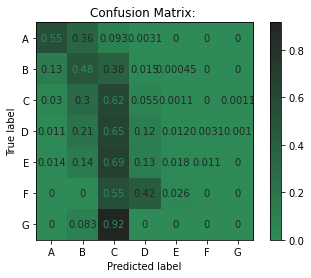

              precision    recall  f1-score   support

           A       0.77      0.55      0.64      2258
           B       0.40      0.48      0.44      2234
           C       0.38      0.62      0.47      1852
           D       0.37      0.12      0.18       971
           E       0.24      0.02      0.03       276
           F       0.00      0.00      0.00        38
           G       0.00      0.00      0.00        12

    accuracy                           0.47      7641
   macro avg       0.31      0.25      0.25      7641
weighted avg       0.49      0.47      0.45      7641




In [35]:
h.plot_classifier_scores(xgb_grade_3,X_grade_val_xgb, y_grade_val, y_hat_val_grade_3, labels_grade)

This model does better, the difference between train and val sets is not so big, and in total we reached better accuracy and recall of first three grades, than in SVMClassifier. Let's try to tune it. All in all this one guesses better the larger grades (with more examples) and worse smaller grades.

* Hyperparameter tuning.

In [ ]:
study = optuna.create_study(direction="maximize", study_name="XGBmulti")
func = lambda trial: h.xgb_objective_multi(trial, X_grade_train_xgb, y_grade_train, preprocessor_acc_xgb)
study.optimize(func, n_trials=10)

In [39]:
trial = study.best_trial
xgb_params_grade2 = trial.params

In [40]:
for key, value in xgb_params_grade2.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value (f1): {study.best_value:.5f}')


		n_estimators: 997
		learning_rate: 0.17895328822760925
		num_leaves: 1480
		max_depth: 3
		reg_alpha: 0.023247724629310334
		reg_lambda: 0.12327667207815357
		scale_pos_weight: 12
	Best value (f1): 0.31803


In [ ]:
xgb_grade_4 = Pipeline(
    steps=[
        ("preprocessorxgb", preprocessor_acc_xgb),
        ("classifier", XGBClassifier(**xgb_params_grade2, random_state=123, use_label_encoder=False)),
    ]
).fit(X_grade_train_xgb, y_grade_train)

y_hat_train_grade4 = xgb_grade_4.predict(X_grade_train_xgb)
y_hat_val_grade4 = xgb_grade_4.predict(X_grade_val_xgb)

In [45]:
y_hat_test_grade4 = xgb_grade_4.predict(X_grade_test_xgb)

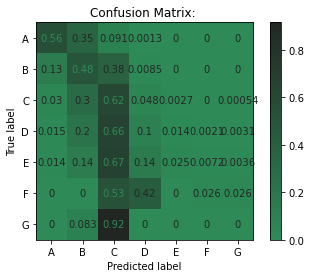

              precision    recall  f1-score   support

           A       0.78      0.56      0.65      2258
           B       0.41      0.48      0.44      2234
           C       0.38      0.62      0.47      1852
           D       0.37      0.10      0.16       971
           E       0.27      0.03      0.05       276
           F       0.20      0.03      0.05        38
           G       0.00      0.00      0.00        12

    accuracy                           0.47      7641
   macro avg       0.34      0.26      0.26      7641
weighted avg       0.50      0.47      0.46      7641




In [42]:
h.plot_classifier_scores(xgb_grade_4,X_grade_val_xgb, y_grade_val, y_hat_val_grade4, labels_grade)

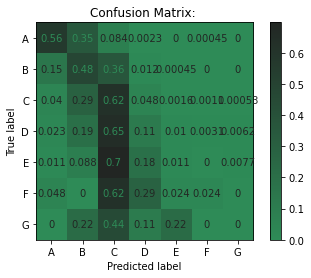

              precision    recall  f1-score   support

           A       0.74      0.56      0.64      2219
           B       0.41      0.48      0.44      2243
           C       0.39      0.62      0.48      1902
           D       0.37      0.11      0.17       966
           E       0.15      0.01      0.02       261
           F       0.14      0.02      0.04        42
           G       0.00      0.00      0.00         9

    accuracy                           0.47      7642
   macro avg       0.31      0.26      0.26      7642
weighted avg       0.49      0.47      0.46      7642




In [46]:
h.plot_classifier_scores(xgb_grade_4,X_grade_test_xgb, y_grade_test, y_hat_test_grade4, labels_grade)

This model actually did best in total, first three grades were predicted better, grades with less observations - worse. Let's see what features got the most importance.

* SHAP values for the grade prediction.

In [43]:
feature_names = X_grade_test_xgb.columns.tolist()

In [48]:
X_grade_test_xgb_tr = preprocessor_acc_xgb.transform(X_grade_test_xgb)
explainer = shap.TreeExplainer(xgb_grade_4["classifier"])
shap_values = explainer.shap_values(X_grade_test_xgb_tr)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


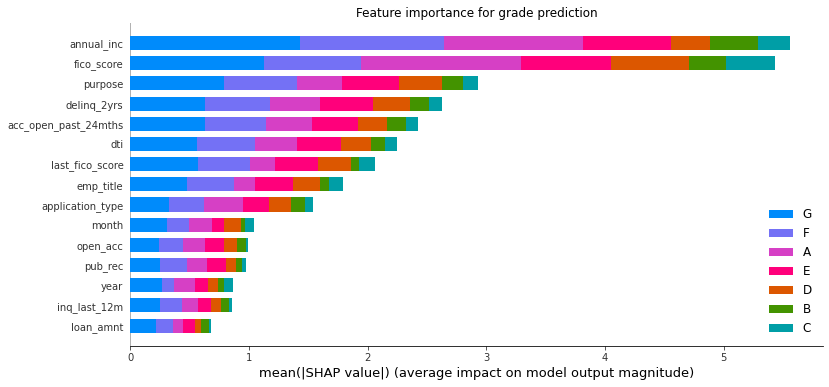

In [49]:
shap.summary_plot(
    shap_values,
    X_grade_test_xgb_tr,
    feature_names=feature_names,
    max_display=15,
    show=False,
    class_names=["A", "B", "C", "D", "E", "F", "G"],
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 5)
ax.set_title("Feature importance for grade prediction", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)

So the most important features for grade prediction in the XGBClassifier were: annual_inc, fico_score, purpose, delinq_2_yrs. But we can see that for different grades the importance of these features differs. 
I tried to up sample smaller grades with SMOTE, but it took unreasonable amount of time to train.

In [50]:
# filename = "model_xgb_grade.joblib"
# dump(xgb_grade_4, filename)

['model_xgb_grade.joblib']

# 4. Sub_grade prediction

I'll try to train XGB classifier, as it did best on loan and grade prediction and to train modules on different grades.

In [89]:
# Training data until 2018
training_df = pd.read_csv("accepted_2013_2017_training.csv")
training_df["grade"].replace(
    [0, 1, 2, 3, 4, 5, 6], ["A", "B", "C", "D", "E", "F", "G"], inplace=True
)
# validation data sample 
test_df = pd.read_csv("accepted_2018_validation.csv")
test_df["grade"].replace(
    [0, 1, 2, 3, 4, 5, 6], ["A", "B", "C", "D", "E", "F", "G"], inplace=True
)

In [90]:
ordinal_features_subgrade = ["application_type", "home_ownership", "purpose", "emp_title", "addr_state", "term"]

In [91]:
ordinal_transformer_subgrade = Pipeline(
    steps=[
        (
            "ordinal_encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        )
    ]
)

preprocessor_sub_grade = ColumnTransformer(
    transformers=[("ordinal", ordinal_transformer_subgrade, ordinal_features_subgrade)],
    remainder="passthrough",
)

This function trains models with default hyperparameters and returns metrics of trained models and the trained model itself.

In [146]:
for grade in ["A", "B", "C", "D", "E", "F", "G"]:
    print(f"Starting training for grade {grade}:")
    result, model = h.train_xgb_subgrade_default(grade, training_df, test_df,  preprocessor_sub_grade)
    print(result)

Starting training for grade A:
        Grade  F1-score  Precision  Recall
A1 - A5     A      0.23       0.25    0.26
Starting training for grade B:
        Grade  F1-score  Precision  Recall
B1 - B5     B      0.21       0.22    0.24
Starting training for grade C:
        Grade  F1-score  Precision  Recall
C1 - C5     C      0.20       0.22    0.23
Starting training for grade D:
        Grade  F1-score  Precision  Recall
D1 - D5     D      0.19       0.21    0.20
Starting training for grade E:
        Grade  F1-score  Precision  Recall
E1 - E5     E      0.23       0.24    0.25
Starting training for grade F:
        Grade  F1-score  Precision  Recall
F1 - F5     F      0.23       0.23    0.24
Starting training for grade G:
        Grade  F1-score  Precision  Recall
G1 - G5     G      0.16       0.19    0.17


We have similar situation to Grade prediction. Sub-grades with smaller observation sizes have worst results. Also overall results became worse. From this we see, that to train one model for all 35 sub_grades is non sense, as the performance would be even worse.

* I Tried to tune and build one model of class "A", as got largest F1 score in the previous session, but the results did not get any better. So, I quit and saved the model for sub_grade of grade "A" with default hyper parameters.

In [92]:
train = training_df[training_df["grade"] == "A"]
X_train = train.drop(columns = [
        "grade", 
        "sub_grade",
        "int_rate",
        "status",
        "cos_month",
        "sin_month",
        "log_loan_amnt",
        "log_annual_inc",
        "log_avg_cur_bal",
        "log_dti",
        "log_fico_score",
        "log_last_fico_score",])
y_train = train.sub_grade

test = test_df[test_df["grade"] == "A"]
X_test = test.drop(columns = [
        "sub_grade", 
        "grade",        
        "int_rate",
        "status",
        "cos_month",
        "sin_month",
        "log_loan_amnt",
        "log_annual_inc",
        "log_avg_cur_bal",
        "log_dti",
        "log_fico_score",
        "log_last_fico_score",])
y_test = test.sub_grade

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
study = optuna.create_study(direction="maximize", study_name="XGBmulti")
func = lambda trial: h.xgb_objective_multi(trial, X_train, pd.DataFrame(y_train), preprocessor_sub_grade)
study.optimize(func, n_trials=20)

In [11]:
trial = study.best_trial
xgb_params_sub = trial.params

In [12]:
for key, value in xgb_params_sub.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value (f1): {study.best_value:.5f}')


		n_estimators: 286
		learning_rate: 0.21364205441333542
		num_leaves: 1300
		max_depth: 10
		reg_alpha: 1.3468347022797889
		reg_lambda: 66.38974436276669
		scale_pos_weight: 51
	Best value (f1): 0.34692


In [13]:
xgb_sub_A = Pipeline(
    steps=[
        ("preprocessor", preprocessor_sub_grade),
        ("classifier", XGBClassifier(**xgb_params_sub,verbosity=0, random_state=123, use_label_encoder=False)),
    ]
).fit(X_train, y_train)

y_pred_train = xgb_sub_A.predict(X_train)
y_pred_test = xgb_sub_A.predict(X_test)

In [14]:
labels_sub = list(encoder.classes_)

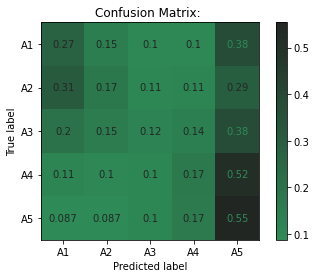

              precision    recall  f1-score   support

          A1       0.28      0.27      0.28     17502
          A2       0.23      0.17      0.20     15276
          A3       0.22      0.12      0.16     16919
          A4       0.29      0.17      0.21     21020
          A5       0.26      0.55      0.35     17589

    accuracy                           0.26     88306
   macro avg       0.26      0.26      0.24     88306
weighted avg       0.26      0.26      0.24     88306




In [15]:
h.plot_classifier_scores(xgb_sub_A,X_test, y_test, y_pred_test, labels_sub)

So we got a little bit better result of accuracy in total, but all in all almost all subgrades of grade A are predicted quite equally. I will save this tuned XGBClassifier of sub grades of grade A. In the same way would be trained modules for all grades.

In [16]:
# filename = "model_xgb_sub.joblib"
# dump(xgb_sub_A, filename)

['model_xgb_sub.joblib']

# 5. Interest rate prediction

## 5.1. Feature pre-processing, base line model

The same all training can be done with every grade of the loans, but I decided to train only a model of grade "A", as training all data set took all night only of the base model. And the results of all data are unpleasant. Grade, sub grade and interest rate are interrelated and interest rate varies in the certain grade, according to it, so it just cannot be separated.

In [4]:
# Training data of grade "A"
training_df = training_df[training_df["grade"] == "A"]

# validation data sample 
test_df = test_df[test_df["grade"] == "A"]

In [5]:
X_train_int = training_df.drop(columns=["grade", "sub_grade", "int_rate", "status"], axis=1)
y_train_int = training_df.int_rate

In [6]:
X_test_int = test_df.drop(columns=["grade", "sub_grade", "int_rate", "status"], axis=1)
y_test_int = test_df.int_rate

In [7]:
# emp_length - passthrough
numeric_features_int = [
    "loan_amnt",
    "annual_inc",
    "dti",
   	"delinq_2yrs",
    "inq_last_6mths",
    "open_acc",	
    "pub_rec",
    "total_acc",
    "inq_last_12m",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "mo_sin_old_il_acct",
    "mort_acc",
    "pct_tl_nvr_dlq",
    "pub_rec_bankruptcies",
    "fico_score",
    "last_fico_score",
    "month",
    "year",	
    "earliest_cr_line_year",
    "cos_month",
    "sin_month",
    "log_loan_amnt",
    "log_annual_inc",
    "log_avg_cur_bal",
    "log_dti",
    "log_fico_score",
    "log_last_fico_score"
]

ordinal_features_int = ["application_type", "term"]
one_hot_features_int = ["home_ownership", "purpose", "emp_title"]
binary_features_int = ["addr_state"]

In [8]:
one_hot_transformer_int = Pipeline(
    steps=[("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

binary_transformer_int = Pipeline(
    steps=[("binary_encoder", ce.BinaryEncoder(cols=binary_features_int))]
)

numeric_transformer_int = Pipeline(steps=[("scaler", StandardScaler())])

ordinal_transformer_int = Pipeline(
    steps=[
        (
            "ordinal_encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        )
    ]
)

preprocessor_int = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer_int, numeric_features_int),
        ("one_hot", one_hot_transformer_int, one_hot_features_int),
        ("binary", binary_transformer_int, binary_features_int),
        ("ordinal", ordinal_transformer_int, ordinal_features_int),
    ],
    remainder="passthrough",
)

In [25]:
# base_line_regression_A_int_rate = h.base_line_regression(X_train_int, y_train_int, preprocessor_int)

In [26]:
# base_line_regression_A_int_rate

,Mean_absolute_error,Mean_squared_error,Root_mean_squared_error,R2,Fit time
Elastic Net,0.84,1.00,1.00,-0.00,0.44
SVR,0.65,0.72,0.85,0.29,960.85
XGB Regressor,0.66,0.68,0.83,0.32,6.18
LGBM Regressor,0.66,0.67,0.82,0.33,1.18


The fitting time was enormous, so I'll continue with LGBM Regressor as it had one of the best Root mean squared error  and fitting time.

## 5.2. LGBM Regressor

With all the same features and hyperparameter tuning.

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBMRegressor")
func = lambda trial: h.LGBM_regressor_objective(trial, X_train_int, y_train_int, preprocessor_int)
study.optimize(func, n_trials=10)

In [ ]:
trial = study.best_trial
lgbm_reg_params = trial.params

In [63]:
for key, value in lgbm_reg_params.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value: {study.best_value:.5f}')


		n_estimators: 1234
		reg_alpha: 0.3707016624572046
		reg_lambda: 3.6457791876849215
		colsample_bytree: 0.8
		subsample: 0.8
		learning_rate: 0.017
		max_depth: 20
		num_leaves: 184
		min_child_samples: 68
		min_data_per_groups: 82
	Best value: 0.82322


In [ ]:
lgbm_reg_int_rate = Pipeline(
    steps=[("preprocessor", preprocessor_int), ("regressor", LGBMRegressor(n_estimators=1234, 
		reg_alpha=0.3707016624572046,
		reg_lambda=3.6457791876849215,
		colsample_bytree=0.8,
		subsample=0.8,
		learning_rate=0.017,
		max_depth=20,
		num_leaves=184,
		min_child_samples=68))]
)
lgbm_reg_int_rate.fit(X_train_int, y_train_int)

In [12]:
# predict future values
y_hat_train_int = lgbm_reg_int_rate.predict(X_train_int)
y_hat_test_int = lgbm_reg_int_rate.predict(X_test_int)

In [13]:
# Print respective output scores
print(f"rmse: {np.sqrt(mean_squared_error(y_train_int, y_hat_train_int))}")

rmse: 0.6446858066871254


In [14]:
# Print respective output scores
print(f"rmse: {np.sqrt(mean_squared_error(y_test_int, y_hat_test_int))}")

rmse: 0.9616042065870954


So it went worse that in the baseline model. Let's try with default hyperparameters.

* LGBMRegressor with default hyperparameters.

In [ ]:
lgbm_reg_int_rate2 = Pipeline(
    steps=[("preprocessor", preprocessor_int), ("regressor", LGBMRegressor())]
)
lgbm_reg_int_rate2.fit(X_train_int, y_train_int)

In [16]:
# predict future values
y_hat_train_int2 = lgbm_reg_int_rate2.predict(X_train_int)
y_hat_test_int2 = lgbm_reg_int_rate2.predict(X_test_int)

In [17]:
# Print respective output scores
print(f"rmse: {np.sqrt(mean_squared_error(y_train_int, y_hat_train_int2))}")

rmse: 0.800221839033761


In [18]:
# Print respective output scores
print(f"rmse: {np.sqrt(mean_squared_error(y_test_int, y_hat_test_int2))}")

rmse: 0.9397368301065612


RMSE on test data got a little bit better. But I think the problem could be too many features.

* The last try, I think, that "raw" features: no scaling, no engineering, only with Ordinal Encoder.

In [20]:
X_train_int_raw = X_train_int.drop(
    columns=[
        "cos_month",
        "sin_month",
        "log_loan_amnt",
        "log_annual_inc",
        "log_avg_cur_bal",
        "log_dti",
        "log_fico_score",
        "log_last_fico_score",
    ]
)

X_test_int_raw = X_test_int.drop(
    columns=[
        "cos_month",
        "sin_month",
        "log_loan_amnt",
        "log_annual_inc",
        "log_avg_cur_bal",
        "log_dti",
        "log_fico_score",
        "log_last_fico_score",
    ]
)

In [23]:
ordinal_features_int_raw = ["application_type", "term", "home_ownership", "purpose", "emp_title", "addr_state"]

In [24]:
preprocessor_int_raw = ColumnTransformer(
    transformers=[
        ("ordinal", ordinal_transformer_int, ordinal_features_int_raw),
    ],
    remainder="passthrough",
)

In [ ]:
lgbm_reg_int_rate3 = Pipeline(
    steps=[("preprocessor", preprocessor_int_raw), ("regressor", LGBMRegressor())]
)
lgbm_reg_int_rate3.fit(X_train_int_raw, y_train_int)

In [26]:
# predict future values
y_hat_train_int3 = lgbm_reg_int_rate3.predict(X_train_int_raw)
y_hat_test_int3 = lgbm_reg_int_rate3.predict(X_test_int_raw)

In [27]:
# Print respective output scores
print(f"rmse: {np.sqrt(mean_squared_error(y_train_int, y_hat_train_int3))}")

rmse: 0.8000245424139456


In [28]:
# Print respective output scores
print(f"rmse: {np.sqrt(mean_squared_error(y_test_int, y_hat_test_int3))}")

rmse: 0.9402224053239102


* Let's try to tune hyper parameters.

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBMRegressor")
func = lambda trial: h.LGBM_regressor_objective(trial, X_train_int_raw, y_train_int, preprocessor_int_raw)
study.optimize(func, n_trials=10)

In [30]:
trial = study.best_trial
lgbm_reg_raw_params = trial.params

In [31]:
for key, value in lgbm_reg_raw_params.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value: {study.best_value:.5f}')


		n_estimators: 3022
		reg_alpha: 0.0037494487732711887
		reg_lambda: 0.08180066280420766
		colsample_bytree: 0.8
		subsample: 0.6
		learning_rate: 0.006
		max_depth: 10
		num_leaves: 418
		min_child_samples: 288
		min_data_per_groups: 46
	Best value: 0.81859


In [ ]:
lgbm_reg_int_rate4 = Pipeline(
    steps=[("preprocessor", preprocessor_int_raw), ("regressor", LGBMRegressor(**lgbm_reg_raw_params))]
)
lgbm_reg_int_rate4.fit(X_train_int_raw, y_train_int)

In [33]:
# predict future values
y_hat_train_int4 = lgbm_reg_int_rate4.predict(X_train_int_raw)
y_hat_test_int4 = lgbm_reg_int_rate4.predict(X_test_int_raw)

In [34]:
# Print respective output scores
print(f"rmse: {np.sqrt(mean_squared_error(y_train_int, y_hat_train_int4))}")

rmse: 0.7420074834821065


In [35]:
# Print respective output scores
print(f"rmse: {np.sqrt(mean_squared_error(y_test_int, y_hat_test_int4))}")

rmse: 0.959937656018598


On test data RMSE got a little bit lower. I chose to save the lgbm_reg_int_rate3 model with default hyper parameters and lower number of features.

In [36]:
# filename = "model_lgbm_int.joblib"
# dump(lgbm_reg_int_rate3, filename)

['model_lgbm_int.joblib']

Conclusions:

**1. Loan acceptance/rejection prediction:**
* baseline module showed that best results by F1 and ROC AUC score were from XGBoost and LGBM Classifier, Logistic regression, SVM Classifier did not do so well;
* best idea was to give tree based module "raw" features (no engineering (like log of values, or sin/cos of month), no scaling), using only Ordinal Encoder fot the categorical variables. In this way the number of features did not increase and the results of XGBClassifier were pretty good.
* most important features in XGBClassifier were: dti, emp_length, addr_state and fico_score (but very individually, as for some cases the same feature could have increased the final probability towards "1" and in other cases decrease, that's because the feature correlates with each other too). The same features were shown as the most important in the LGBM Classifier too.
* best probability threshold should be 0.7499 according to this training data set.

**2. Grade prediction:**
* Support Vector Machines Classifier on validation data reached only 0.38 of total accuracy, it predicted better classes with more observation and worse with less. By permutation importance test: most important features were: credit_card, annual income, log_loan_amnt, inq_last_12_months, purpose_debt_consolidation. 
* XGBClassifier: trained on the whole data set of accepted loans from the year from 2013 to 2017 and validated on the sample of the year 2018, showed best result, but in total the accuracy on unseen data reached only 0.48. Shap values showed, that the most important features were: annual_inc, fico_score, purpose, delinq_2_yrs. But we can see that for different grades the importance of these features differs. 

**3. Sub_grade prediction:**
* Grade, sub_grade and interest rate are very related, actually, when the grade is predicted, the sub_grade varies only in that grade. So I decided to train model in each grade class and saved only the model of grade "A", but the results are not satisfying, for further improvement, I would investigate each grade group and try the base line models on each grade group, as I think the patterns there varies quite a lot.

**4. Interest rate prediction:**
* Interest rate is inseparable from grade and sub grade. In the EDA part we saw how interest rate varies in every grade class, so  to train it on all data, in my opinion, was inefficient. I tried to train the module to predict interest rate in the grade "A". The same approach could be to train in all grades. The base line model showed quite equal results of RMSE from Elastic Net, SVR, XGB Regressor and LGBM Regressor, but the fitting time in SVR was enormous. The tuned LGBM Regressor showed the RMSE = 0.94. I think the main point, why RMSE on test data went so low, that this data was from 2018, actually unseen and it could cause worse performance than in the baseline module, but it shows the real life situation, when you get data from next year, that wasn't in the training set. 

* For further improvement I would do step wise hyperparameter tuning, as now it took ages to tune tons of different parameters at once and it's not so effective I think.
* For further improvement on grade, sub-grade and interest rate prediction, I would investigate features again. I already dropped features with very little variance in the EDA, but if I would have had more information about the time, when each of features was registered, I think I could choose more of them and combine some of them together. As some averages of money in credit cards were suspicious to me, I did not know when this data was recorded, after the loan acceptance or before.
